Imports done
20
append done


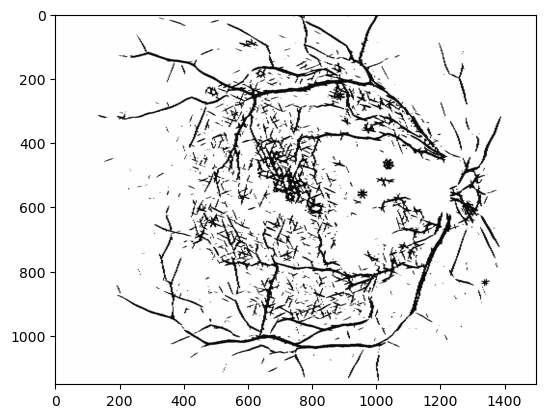

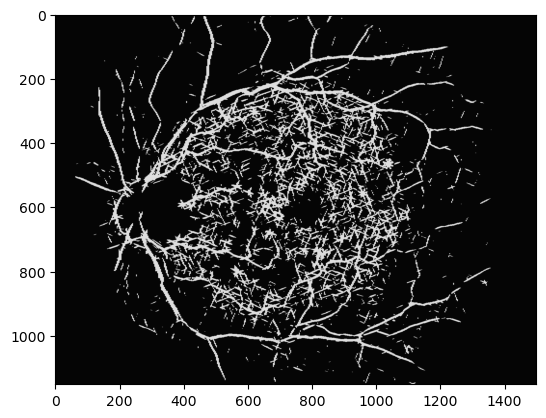

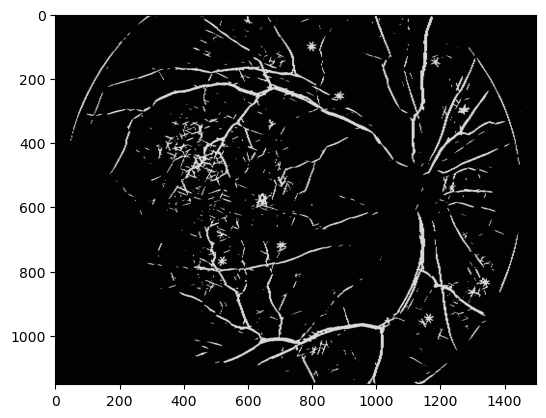

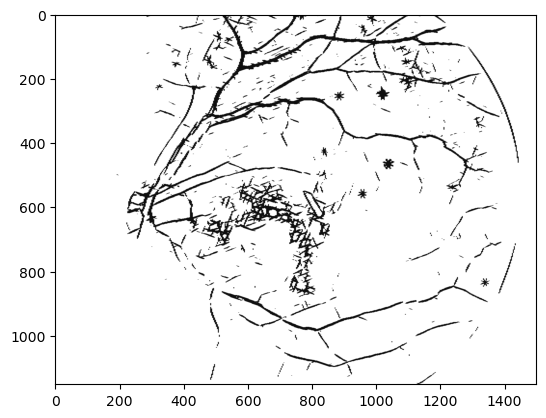

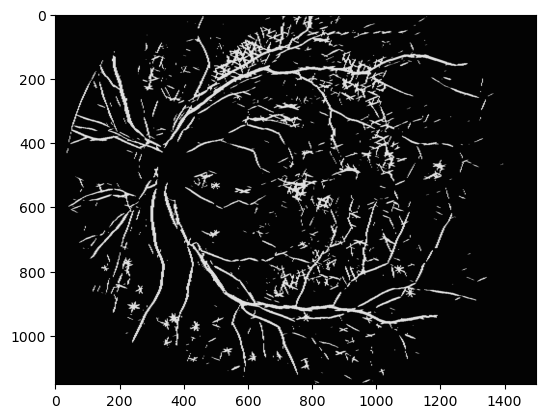

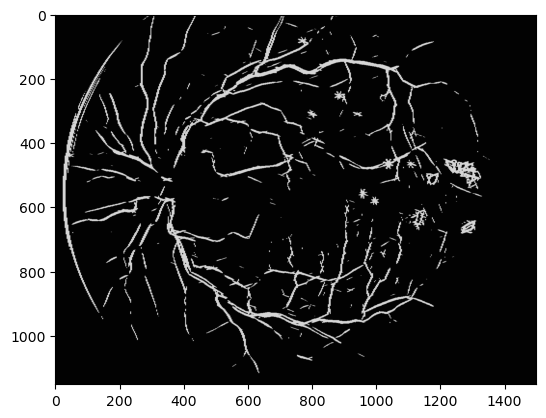

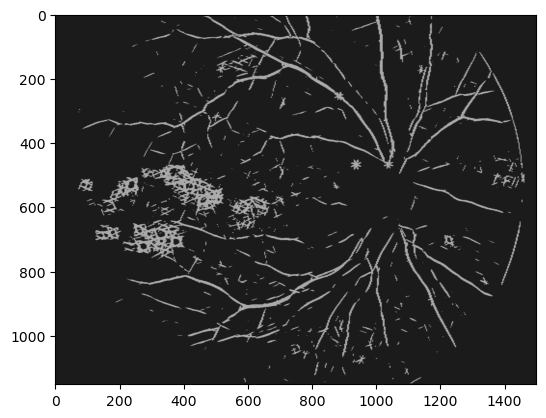

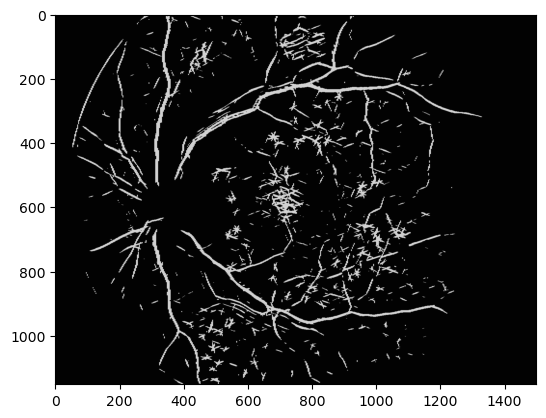

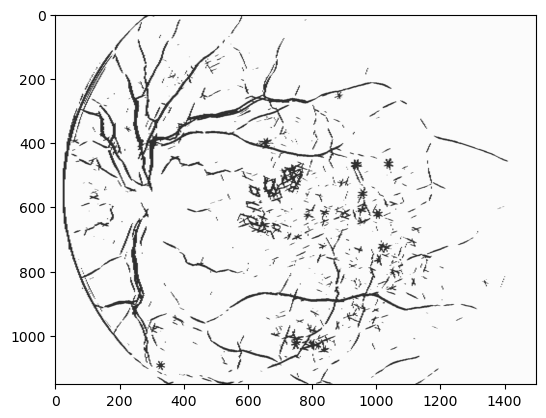

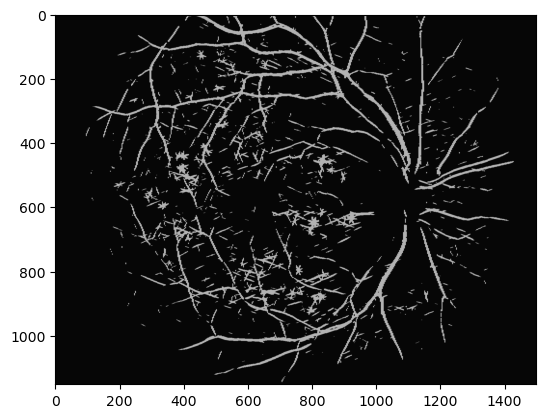

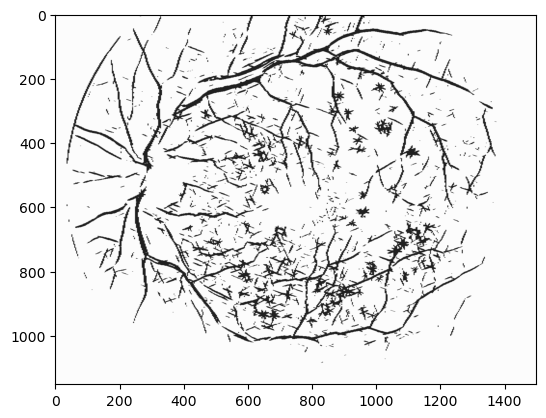

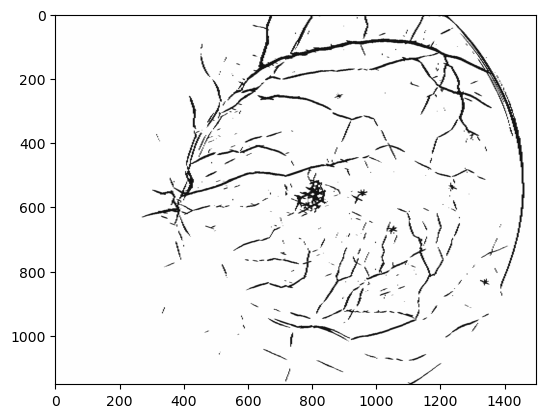

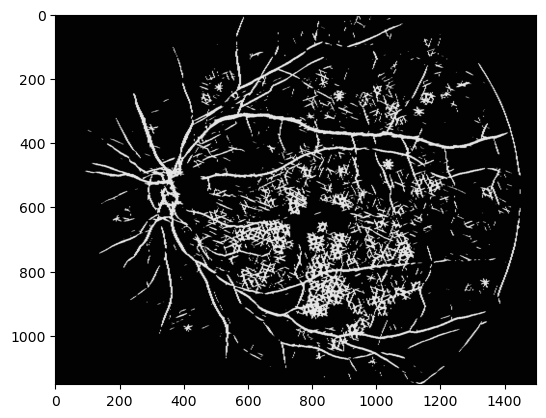

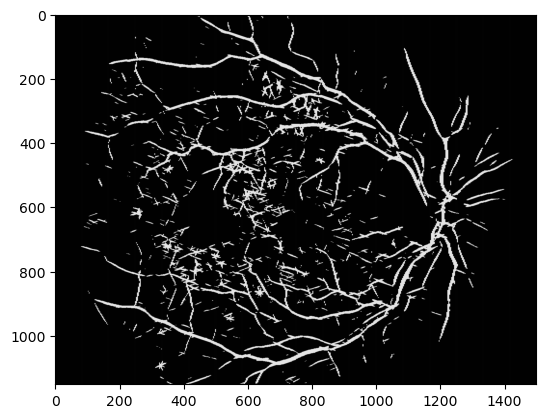

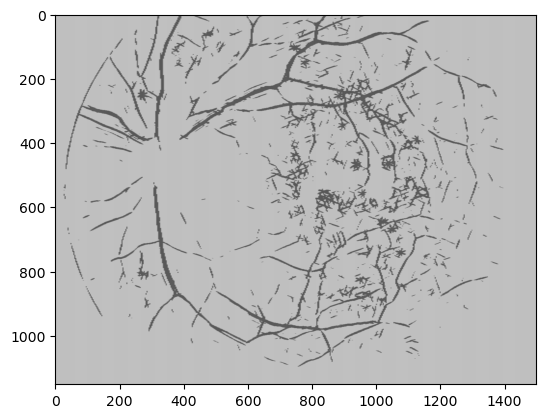

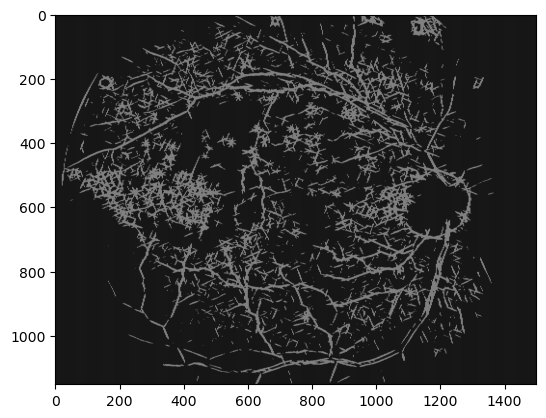

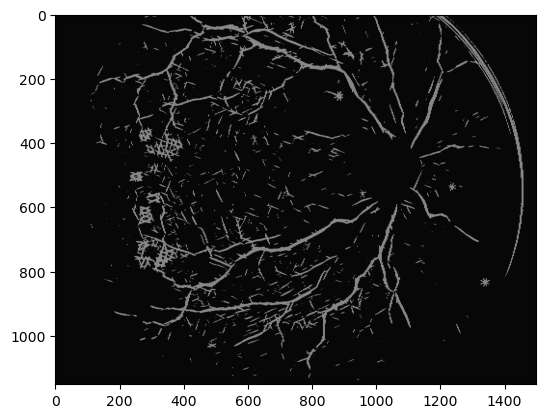

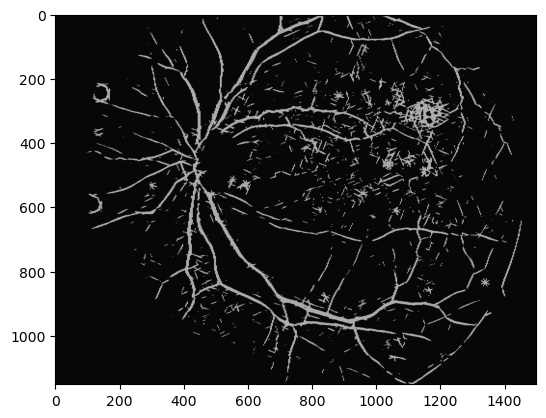

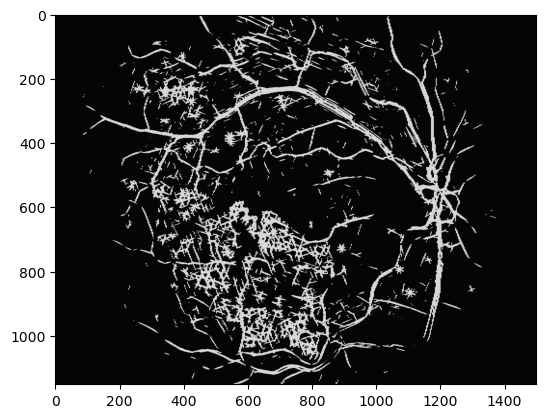

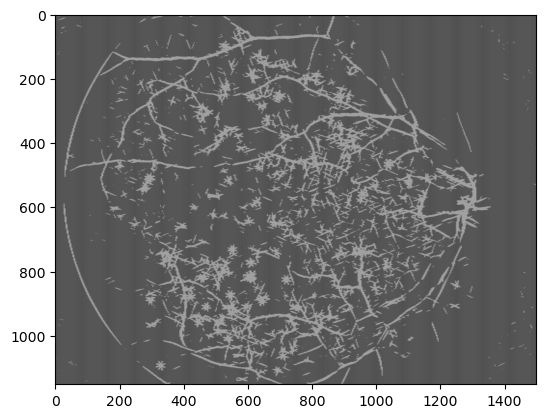

In [2]:
from PIL import Image
from sklearn import svm
import scipy
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pywt
import os

print('Imports done')

immatrix=[]
im_unpre = []
lenpath=len(list(os.listdir('C:/Users/G Harsh Vardhan/Desktop/Projects/diabetic retinopathy/dataset/data')))
print(lenpath)
for i in range(1,lenpath+1):
    img_pt = r'C:\Users\G Harsh Vardhan\Desktop\Projects\diabetic retinopathy\dataset\data\image'
    if i < 10:
        img_pt = img_pt + "00" + str(i) + ".png"
    else:
        img_pt = img_pt + "0" + str(i)+ ".png"

    img = cv2.imread(img_pt)
    #gray scale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #equilize image
    equ = cv2.equalizeHist(img_gray)
    #append image binary data into immatrix 
    immatrix.append(np.array(equ).flatten())

print('append done')

imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((1152,1500))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())


def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


def gaussian_matched_filter_kernel(L, sigma, t = 3):
    #sixth function
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

#Given a filter bank, apply them and record maximum response

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

#fourth funnction
gf = gaussian_matched_filter_kernel(20, 5)
#fifth funtion
bank_gf = createMatchedFilterBank(gf, 4)

#training matrix
imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1152,1500))
    #third funtion
    #applies filter on imm_dwt in which binary data of image is stored
    equ3 = applyFilters(equ2,bank_gf)
    #appending binary image after applying  filter
    imm_gauss.append(np.array(equ3).flatten())



def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        #to remove unwanted distortions GarborKernel is used
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

#first function
bank_gf = createMatchedFilterBank()

imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1152,1500))
    #second function
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())


e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,3))
np.shape(e_)


img = equ3
Z = img.reshape((-1,3))

Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
#kmeans clustering
#kmeans(data,k no of clusters,criteria,attempts,flags)
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)


center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))


imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((1152,1500))
    Z = img.reshape((-1,3))

    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())


for i in range(lenpath):
    np.shape(imm_kmean)
    plt.imshow(imm_kmean[i].reshape((1152,1500)),cmap="gray")
    plt.show()



In [4]:
from sklearn.svm import SVC
clf = SVC()
Y = np.ones(20)
Y[1]=Y[5]=Y[7]=Y[17]=Y[6]=0

clf.fit(imm_kmean, Y)
print('Training done')

Training done


In [5]:
y_pred = clf.predict(imm_kmean)


import sklearn

sklearn.metrics.accuracy_score(Y,y_pred)


0.75

1
append done


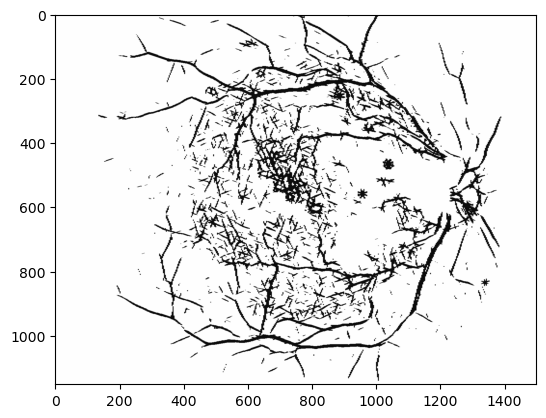

In [6]:
#Training
immatrix=[]
im_unpre = []
lenpath=len(list(os.listdir('C:/Users/G Harsh Vardhan/Desktop/Projects/diabetic retinopathy/dataset/predict')))
print(lenpath)
for i in range(1,lenpath+1):
    img_pt = r'C:\Users\G Harsh Vardhan\Desktop\Projects\diabetic retinopathy\dataset\predict\image'
    if i < 10:
        img_pt = img_pt + "00" + str(i) + ".png"
    else:
        img_pt = img_pt + "0" + str(i)+ ".png"

    img = cv2.imread(img_pt)
    #gray scale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #equilize image
    equ = cv2.equalizeHist(img_gray)
    #append image binary data into immatrix 
    immatrix.append(np.array(equ).flatten())

print('append done')

imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((1152,1500))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())


def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


def gaussian_matched_filter_kernel(L, sigma, t = 3):
    #sixth function
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

#Given a filter bank, apply them and record maximum response

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

#fourth funnction
gf = gaussian_matched_filter_kernel(20, 5)
#fifth funtion
bank_gf = createMatchedFilterBank(gf, 4)

#training matrix
imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1152,1500))
    #third funtion
    #applies filter on imm_dwt in which binary data of image is stored
    equ3 = applyFilters(equ2,bank_gf)
    #appending binary image after applying  filter
    imm_gauss.append(np.array(equ3).flatten())



def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        #to remove unwanted distortions GarborKernel is used
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

#first function
bank_gf = createMatchedFilterBank()

imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((1152,1500))
    #second function
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())


e_ = equ3
np.shape(e_)
e_=e_.reshape((-1,3))
np.shape(e_)


img = equ3
Z = img.reshape((-1,3))

Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
#kmeans clustering
#kmeans(data,k no of clusters,criteria,attempts,flags)
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)


center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))


imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((1152,1500))
    Z = img.reshape((-1,3))

    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())
    
for i in range(lenpath):
    np.shape(imm_kmean)
    plt.imshow(imm_kmean[i].reshape((1152,1500)),cmap="gray")
    plt.show()